<a href="https://colab.research.google.com/github/MateusFauri/TensorFlow-/blob/main/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature Extraction


In [ ]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2023-03-11 18:17:59--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 74.125.68.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  18.0MB/s    in 9.8s    

2023-03-11 18:18:09 (16.4 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size = IMAGE_SHAPE,
                                               batch_size = BATCH_SIZE,
                                               class_mode = "categorical")

test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size = IMAGE_SHAPE,
                                             batch_size = BATCH_SIZE,
                                             class_mode = "categorical")

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


## Setting up callbacks

Are extra functionality you can add to your models to be performed during or after training.
Some of the most populars:

* Tracking experiments with the TensorBoard callbacks
* Model checkpoint with the Model
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback

In [ ]:
import datetime
import tensorflow as tf

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

## Create Model with TensorFlow Hub
We can accesses models in: 
https://tfhub.dev/

* exemple below is from: https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1 

In [ ]:
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
def create_model(model_url, num_classes=1):
  """
    Takes a tensorFlow Hub URL and creates a Keras Sequential model with it.

    Args:
      model_url (str): A TensorFlow Hub feature extraction URL.
      num_classes (int): Number of output neurons in the output layer,
        should be equal to number of target classes, default 1.

    Returns:
      An uncompiled Keras Sequential model with model_url as feature extractor
      layer and Dense outpu layer with num_classes output neurons.
  """

  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name="feature_extractor_layer")

  model = tf.keras.Sequential([
        feature_extractor_layer,
        layers.Dense(num_classes, activation="softmax", name="output_layer")
        ])

  return model

# Creating and testing ResNet TensorFlow Hub Feature Extraction model

In [ ]:
resnet_model = create_model(resnet_url, num_classes=train_data.num_classes)

In [ ]:
resnet_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

resnet_history = resnet_model.fit(train_data,
                           epochs=5,
                           steps_per_epoch=len(train_data),
                           validation_data=test_data,
                           validation_steps=len(test_data),
                           callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                  experiment_name="resnet50V2")])


Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20230302-214544


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Epoch 1/5
24/24 [==============================] - 26s 898ms/step - loss: 1.9095 - accuracy: 0.3667 - val_loss: 1.2422 - val_accuracy: 0.5812
Epoch 2/5
24/24 [==============================] - 18s 775ms/step - loss: 0.9036 - accuracy: 0.7373 - val_loss: 0.8851 - val_accuracy: 0.7172
Epoch 3/5
24/24 [==============================] - 20s 856ms/step - loss: 0.6110 - accuracy: 0.8307 - val_loss: 0.7581 - val_accuracy: 0.7496
Epoch 4/5
24/24 [==============================] - 18s 750ms/step - loss: 0.4681 - accuracy: 0.8867 - val_loss: 0.7042 - val_accuracy: 0.7680
Epoch 5/5
24/24 [==============================] - 18s 777ms/step - loss: 0.3771 - accuracy: 0.9147 - val_loss: 0.6870 - val_accuracy: 0.7736


In [ ]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  """
    Return separate loss curves for training and validation metrics.

    Args:
      History: TensorFlow History object.

    Returns:
      Plots of training/validation loss and accuracy metrics
  """  

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

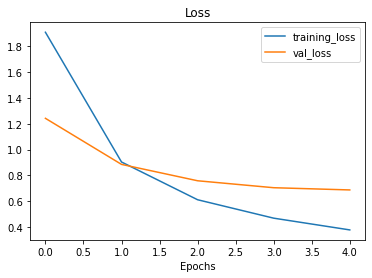

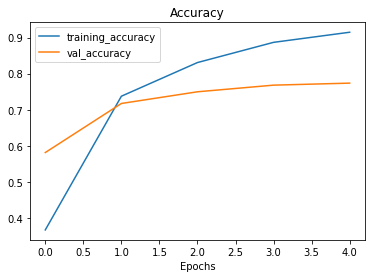

In [ ]:
plot_loss_curves(resnet_history)

## Creating and testing EfficientNetB0 TensorFlow Hub Feature Extraction model

In [ ]:
from keras.api._v2.keras.losses import CategoricalCrossentropy
efficientnet_model = create_model(efficientnet_url, num_classes=train_data.num_classes)

efficientnet_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])

efficientnet_history = efficientnet_model.fit(train_data,
                                              epochs=10,
                                              steps_per_epoch = len(train_data),
                                              validation_data = test_data,
                                              validation_steps= len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                  experiment_name="efficientnetB0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20230302-214747
Epoch 1/10
24/24 [==============================] - 38s 1s/step - loss: 1.8134 - accuracy: 0.4613 - val_loss: 1.2525 - val_accuracy: 0.7420
Epoch 2/10
24/24 [==============================] - 24s 1s/step - loss: 1.0325 - accuracy: 0.7760 - val_loss: 0.8489 - val_accuracy: 0.8208
Epoch 3/10
24/24 [==============================] - 26s 1s/step - loss: 0.7474 - accuracy: 0.8333 - val_loss: 0.6888 - val_accuracy: 0.8428
Epoch 4/10
24/24 [==============================] - 23s 1s/step - loss: 0.5999 - accuracy: 0.8680 - val_loss: 0.6061 - val_accuracy: 0.8552
Epoch 5/10
24/24 [==============================] - 25s 1s/step - loss: 0.5092 - accuracy: 0.8867 - val_loss: 0.5560 - val_accuracy: 0.8612
Epoch 6/10
24/24 [==============================] - 21s 906ms/step - loss: 0.4404 - accuracy: 0.9000 - val_loss: 0.5185 - val_accuracy: 0.8640
Epoch 7/10
24/24 [==============================] - 17s 747ms/step - loss: 0.3

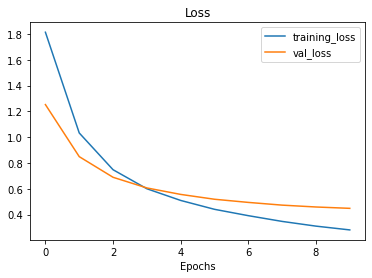

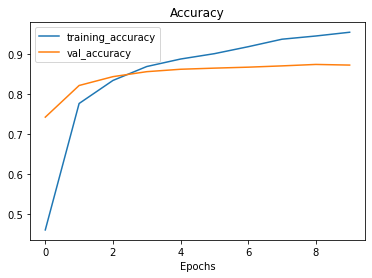

In [ ]:
plot_loss_curves(efficientnet_history)

## Different types of transfer learning

* **"As is"** transfer learning - using an existing model with no changes what so ever.
* **"Feature extraction"** transfer learning - use the prelearned patterns of an existing model and adjust the output layer for your own problem
* **"Fine-tuning"** transfer learning -  use the prelearned patterns of an existing model and "fine-tune"many or all of the underlying layers (including new output layers)

# Comparing our models results using TensorBoard


> **Note:** When upload things to TensorBoard.dev, the experiments are public!!

In [ ]:
# upload TensorBoard dev records
#!tensorboard dev upload --logdir ./tensorflow_hub/ \
#  --name "EfficientNetB0 vs. ResNet50V2" \
#  --description "Comparing two different TF hub feature extraction model architectures" \
#  --one_shot

TensorBoard experiments are uploaded publically here: https://tensorboard.dev/experiment/fq7sbkf9R9moF55s74qeYA/


In [ ]:
#!tensorboard dev list

In [ ]:
#delete a experiment on tensorBoard
# !tensorboard dev delete --experiment_id (experiment_id_here)

# Exercices


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import datetime
import matplotlib.pyplot as plt

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224,224)
#batch size will be the default - 32

train_data = "10_food_classes_10_percent/train/"
test_data = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

train_data = train_datagen.flow_from_directory(train_data,
                                               target_size = IMAGE_SHAPE,
                                               class_mode="categorical")

test_data = test_datagen.flow_from_directory(test_data,
                                             target_size = IMAGE_SHAPE,
                                             class_mode="categorical")

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [ ]:
mobilenet_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5"

feacture_extractor_layer = hub.KerasLayer(mobilenet_url,
                                          trainable=False)

mobile_model = tf.keras.Sequential([
    feacture_extractor_layer,
    tf.keras.layers.Dense(10, activation="softmax")
])

mobile_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

mobile_history = mobile_model.fit(train_data,
                                  epochs=5,
                                  steps_per_epoch=len(train_data),
                                  validation_data=test_data,
                                  validation_steps=len(test_data))

Epoch 1/5
24/24 [==============================] - 22s 737ms/step - loss: 1.9042 - accuracy: 0.3520 - val_loss: 1.2283 - val_accuracy: 0.6656
Epoch 2/5
24/24 [==============================] - 17s 725ms/step - loss: 1.0050 - accuracy: 0.7080 - val_loss: 0.8644 - val_accuracy: 0.7600
Epoch 3/5
24/24 [==============================] - 16s 685ms/step - loss: 0.7151 - accuracy: 0.8000 - val_loss: 0.7254 - val_accuracy: 0.7912
Epoch 4/5
24/24 [==============================] - 18s 784ms/step - loss: 0.5646 - accuracy: 0.8600 - val_loss: 0.6634 - val_accuracy: 0.8092
Epoch 5/5
24/24 [==============================] - 16s 689ms/step - loss: 0.4724 - accuracy: 0.8933 - val_loss: 0.6200 - val_accuracy: 0.8176


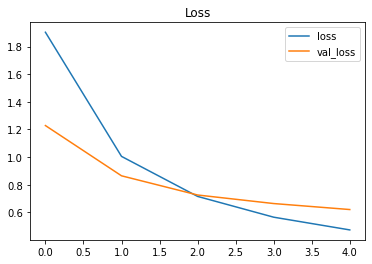

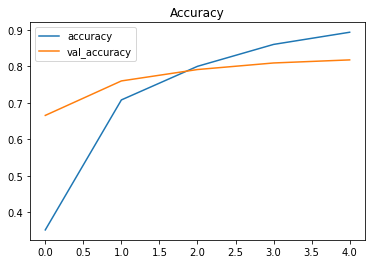

In [ ]:
epochs = range(len(mobile_history.history["loss"]))

plt.plot(epochs, mobile_history.history["loss"], label="loss")
plt.plot(epochs, mobile_history.history["val_loss"], label="val_loss")
plt.title("Loss")
plt.legend()

plt.figure()
plt.plot(epochs, mobile_history.history["accuracy"], label="accuracy")
plt.plot(epochs, mobile_history.history["val_accuracy"], label="val_accuracy")
plt.title("Accuracy")
plt.legend()

# Fine-Tuning


In [ ]:
!wget https://raw.githubusercontent.com/MateusFauri/TensorFlow-/main/helper_functions.py

--2023-03-24 21:39:11--  https://raw.githubusercontent.com/MateusFauri/TensorFlow-/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2886 (2.8K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   2.82K  --.-KB/s    in 0s      

2023-03-24 21:39:11 (47.4 MB/s) - ‘helper_functions.py’ saved [2886/2886]



In [ ]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2023-03-24 21:39:18--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 172.253.117.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   119MB/s    in 1.3s    

2023-03-24 21:39:19 (119 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [ ]:
!pwd


/content


In [ ]:
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

## Using Keras Hub 

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data = image_dataset_from_directory(train_dir,
                                          image_size = IMG_SIZE,
                                          label_mode = "categorical",
                                          batch_size = BATCH_SIZE)

test_data = image_dataset_from_directory(test_dir,
                                         image_size = IMG_SIZE,
                                         label_mode = "categorical",
                                         batch_size = BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
train_data.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

## Keras Functional API

In [ ]:
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)

# Freeze the base model
base_model.trainable = False

inputs = tf.keras.layers.Input(shape=(224,224,3), name = "input_layer")

# if using a model like ResNet50V2 you will need to normalize inputs (don't have to for EfficientNet)
#x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

x = base_model(inputs)

# Average pool the outputs (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

model_0 = tf.keras.Model(inputs, outputs)


model_0.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_0.fit(train_data,
            epochs=5,
            steps_per_epoch=len(train_data),
            validation_data= test_data,
            validation_steps= int(.25 * len(test_data)),
            callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                   experiment_name="10_percent")])

16705208/16705208 [==============================] - 0s 0us/step


Saving TensorBoard log files to: transfer_learning/10_percent/20230302-215355
Epoch 1/5
24/24 [==============================] - 13s 239ms/step - loss: 1.8605 - accuracy: 0.4227 - val_loss: 1.2948 - val_accuracy: 0.7401
Epoch 2/5
24/24 [==============================] - 4s 142ms/step - loss: 1.0809 - accuracy: 0.7707 - val_loss: 0.8765 - val_accuracy: 0.8158
Epoch 3/5
24/24 [==============================] - 6s 200ms/step - loss: 0.7836 - accuracy: 0.8160 - val_loss: 0.7045 - val_accuracy: 0.8322
Epoch 4/5
24/24 [==============================] - 5s 177ms/step - loss: 0.6342 - accuracy: 0.8587 - val_loss: 0.6297 - val_accuracy: 0.8388
Epoch 5/5
24/24 [==============================] - 5s 180ms/step - loss: 0.5401 - accuracy: 0.8800 - val_loss: 0.5692 - val_accuracy: 0.8470


In [ ]:
model_0.evaluate(test_data)

79/79 [==============================] - 6s 70ms/step - loss: 0.5531 - accuracy: 0.8620


[0.5530758500099182, 0.8619999885559082]

In [ ]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 rescaling_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activation
5

## Getting a feacture vector from a trained model

---



In [ ]:
input_shape = (1,4,4,3)

tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]


In [ ]:
global_avarege_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
global_avarege_pooled_tensor

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

In [ ]:
tf.reduce_mean(input_tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

**bold text**# Running a series of transfer learning experiments

Models experiments:
  1. `model_1` - use feature extraction trnasfer learning with 1% of the training data with data augmentation
  2. `model_2` - use feature extraction transfer learning with 10% of the training with data augmentation
  3. `model_3` - use fine-tuning transfer learning on 10% of the training data with data augmentation.
  4. `model_4` - use fine-tuning transfer learning on 100% of the training data with data augmentation.

In [ ]:
!wget https://raw.githubusercontent.com/MateusFauri/TensorFlow-/main/helper_functions.py
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data

--2023-03-02 21:54:43--  https://raw.githubusercontent.com/MateusFauri/TensorFlow-/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2886 (2.8K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]   2.82K  --.-KB/s    in 0s      

2023-03-02 21:54:43 (30.6 MB/s) - ‘helper_functions.py.1’ saved [2886/2886]



## Model_1 



In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

unzip_data("10_food_classes_1_percent.zip")

--2023-03-03 02:31:21--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.192.128, 172.217.219.128, 209.85.147.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.192.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip.2’

10_food_classes_1_p 100%[===================>] 127.42M   145MB/s    in 0.9s    

2023-03-03 02:31:22 (145 MB/s) - ‘10_food_classes_1_percent.zip.2’ saved [133612354/133612354]



In [ ]:
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [ ]:
import tensorflow as tf

In [ ]:
IMG_SIZE = (224,224)
BATCH_SIZE = 32

#setup data loaders

train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           image_size = IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode= "categorical",
                                                                image_size=IMG_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


### Adding data augmentation right into the model

Using:
* `tf.keras.layers.experimental.preprocessing()`

The benefits of using data augmentation inside the model are:
* Preprocessing of images happens on the GPU rather than CPU.
* Image data augmentation only happens during training, so we can still export our whole model and use it elsewhere.

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
   # preprocessing.Rescale(1./255)
], name = "data_augmentation")

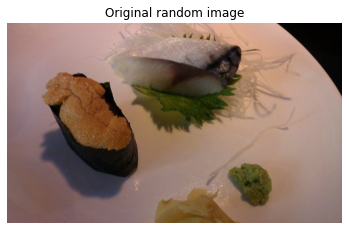

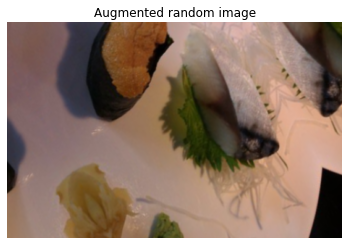

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title("Original random image")
plt.axis(False)

augmented_img = data_augmentation(img) / 255.
plt.figure()
plt.title("Augmented random image")
plt.axis(False)
plt.imshow(augmented_img)

In [ ]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape= input_shape, name="input_layers")

# Add in data augmentation Sequential model as layer
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D()(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

#make a model using the inputs and outputs
model_1 = keras.Model(inputs, outputs)

model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_1 = model_1.fit(train_data_1_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_1_percent),
                        validation_data=test_data,
                        validation_steps= .25 * len(test_data),
                        callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                               experiment_name="1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20230302-221423
Epoch 1/5


3/3 [==============================] - ETA: 0s - loss: 2.3666 - accuracy: 0.1286

3/3 [==============================] - 16s 3s/step - loss: 2.3666 - accuracy: 0.1286 - val_loss: 2.2441 - val_accuracy: 0.1891
Epoch 2/5
3/3 [==============================] - 4s 2s/step - loss: 2.0906 - accuracy: 0.3286 - val_loss: 2.1224 - val_accuracy: 0.2719
Epoch 3/5
3/3 [==============================] - 3s 1s/step - loss: 1.8829 - accuracy: 0.4571 - val_loss: 1.9865 - val_accuracy: 0.3578
Epoch 4/5
3/3 [==============================] - 4s 2s/step - loss: 1.7108 - accuracy: 0.6000 - val_loss: 1.8784 - val_accuracy: 0.4359
Epoch 5/5
3/3 [==============================] - 4s 2s/step - loss: 1.5535 - accuracy: 0.7286 - val_loss: 1.7976 - val_accuracy: 0.4859


In [ ]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layers (InputLayer)   [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, 3)          0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [ ]:
model_1.evaluate(test_data)

79/79 [==============================] - 6s 67ms/step - loss: 1.7919 - accuracy: 0.4980


[1.7919199466705322, 0.49799999594688416]

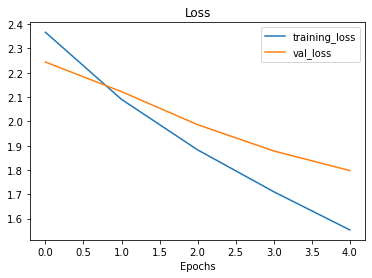

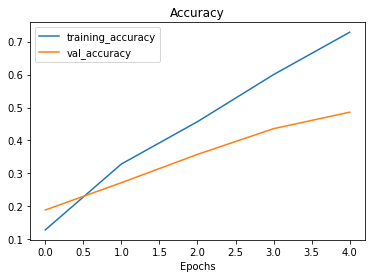

In [ ]:
plot_loss_curves(history_1)

## Model_2


In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

--2023-03-24 21:38:56--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 172.253.117.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   168MB/s    in 1.0s    

2023-03-24 21:38:57 (168 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



NameError: ignored

In [ ]:
import tensorflow as tf

# set data to dataloaders
IMG_SHAPE = (224,224)

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SHAPE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SHAPE)

In [ ]:
data_augmentation = tf.keras.models.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomHeight(.2),
    tf.keras.layers.experimental.preprocessing.RandomWidth(.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(.2),
    tf.keras.layers.experimental.preprocessing.RandomRotation(.2)
], name="data_augmentation")


In [ ]:
input_shape = (224,224,3)

backbone = tf.keras.applications.EfficientNetB0(include_top=False)
backbone.trainable = False

inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")

x = data_augmentation(inputs)
x = backbone(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)

output = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

model_2 = tf.keras.Model(inputs, output)

model_2.compile(loss="categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])


### Creating a ModelCheckpoint callback


In [ ]:
checkpoint_path = "10_percent_model_checkpoints_weights/checkpoint.cktp"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
      filepath = checkpoint_path,
      save_weights_only = True,
      monitor="val_accuracy",
      save_freq="epoch",
      save_best_only = False
)

In [ ]:
history_2 = model_2.fit(train_data_10_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data,
                        validation_steps=int(len(test_data) * .25),
                        callbacks=[model_checkpoint_callback])

Epoch 1/5
24/24 [==============================] - 14s 592ms/step - loss: 1.3075 - accuracy: 0.6813 - val_loss: 0.9782 - val_accuracy: 0.7862
Epoch 2/5
24/24 [==============================] - 14s 569ms/step - loss: 1.0021 - accuracy: 0.7520 - val_loss: 0.7856 - val_accuracy: 0.8141
Epoch 3/5
24/24 [==============================] - 13s 537ms/step - loss: 0.8425 - accuracy: 0.7947 - val_loss: 0.6851 - val_accuracy: 0.8372
Epoch 4/5
24/24 [==============================] - 14s 571ms/step - loss: 0.7510 - accuracy: 0.8120 - val_loss: 0.6121 - val_accuracy: 0.8421
Epoch 5/5
24/24 [==============================] - 13s 525ms/step - loss: 0.6688 - accuracy: 0.8280 - val_loss: 0.5781 - val_accuracy: 0.8438


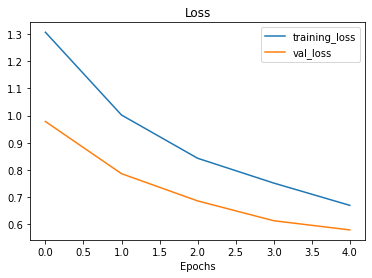

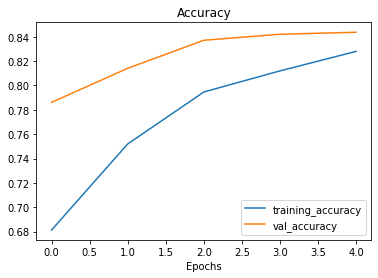

In [ ]:
plot_loss_curves(history_2)

In [ ]:
evaluate_model = model_2.evaluate(test_data)

79/79 [==============================] - 8s 96ms/step - loss: 0.5841 - accuracy: 0.8480


In [ ]:
evaluate_model

[0.5840972065925598, 0.8479999899864197]

### Loading in checkpointed weights

Loading in a checkpoint weights returns a model to a specifc checkpoint

In [ ]:
model_2.load_weights(checkpoint_path)

loaded_weights_model = model_2.evaluate(test_data)

79/79 [==============================] - 7s 79ms/step - loss: 0.5841 - accuracy: 0.8480


In [ ]:
loaded_weights_model

[0.5840973258018494, 0.8479999899864197]

In [ ]:
import numpy as np
np.isclose(np.array(evaluate_model), np.array(loaded_weights_model))


array([ True,  True])

## Model_3

> Fine-tuning usually works best after training a feature extraction model for a few epochs with large amounts of custom data.


In [ ]:
# model 3 is just a fine-tuning version of model 2 for further 5 epochs
model_2.layers

In [ ]:
for layer in model_2.layers:
  print(layer, layer.trainable)

print(len(model_2.layers[2].trainable_variables))

<keras.engine.input_layer.InputLayer object at 0x7fbba4a3b880> True
<keras.engine.sequential.Sequential object at 0x7fbba49fc5b0> True
<keras.engine.functional.Functional object at 0x7fbb9c7128b0> False
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7fbba4a3b970> True
<keras.layers.core.dense.Dense object at 0x7fbb94801ee0> True
0


In [ ]:
for layer in range(-11,0,1):
  backbone.layers[layer].trainable = True

#for layer in backbone.layers:
#  print(layer.name, layer.trainable)

# Recompile (Need to recompile the model every time we make a change)
model_2.compile(loss='categorical_crossentropy',
                optimizer= tf.keras.optimizers.Adam(lr=1e-4),
                metrics=["accuracy"])
# When fine-tuning a model, the best pratice is to lower the learning rate by some amount.
# Here, I low to 1e-3 to 1e-4.

print(len(model_2.trainable_variables))

2


In [ ]:
model_3_history = model_2.fit(train_data_10_percent,
                              epochs=10,
                              initial_epoch=history_2.epoch[-1], #start training from previus last epoch
                              validation_data=test_data,
                              validation_steps=int(.25*len(test_data)))

Epoch 5/10


24/24 [==============================] - 35s 648ms/step - loss: 0.6121 - accuracy: 0.8373 - val_loss: 0.5301 - val_accuracy: 0.8569
Epoch 6/10
24/24 [==============================] - 16s 645ms/step - loss: 0.5515 - accuracy: 0.8600 - val_loss: 0.5225 - val_accuracy: 0.8536
Epoch 7/10
24/24 [==============================] - 12s 497ms/step - loss: 0.5088 - accuracy: 0.8680 - val_loss: 0.4915 - val_accuracy: 0.8586
Epoch 8/10
24/24 [==============================] - 14s 553ms/step - loss: 0.4758 - accuracy: 0.8760 - val_loss: 0.4882 - val_accuracy: 0.8569
Epoch 9/10
24/24 [==============================] - 12s 485ms/step - loss: 0.4512 - accuracy: 0.8947 - val_loss: 0.4553 - val_accuracy: 0.8684
Epoch 10/10
24/24 [==============================] - 12s 474ms/step - loss: 0.4090 - accuracy: 0.8947 - val_loss: 0.4668 - val_accuracy: 0.8536


In [ ]:
result_model_3 = model_2.evaluate(test_data)

79/79 [==============================] - 10s 113ms/step - loss: 0.4610 - accuracy: 0.8596


In [ ]:
result_model_3 , evaluate_model

([0.46102002263069153, 0.8596000075340271],
 [0.5840972065925598, 0.8479999899864197])

In [ ]:
import matplotlib.pyplot as plt

def compare_historys(original, new, initial_epochs=5):
  """
    Compares two TensorFlow History objects.
  """

  acc = original.history["accuracy"]
  loss = original.history["loss"]

  val_acc = original.history["val_accuracy"]
  val_loss = original.history["val_loss"]

  total_acc = acc + new.history["accuracy"]
  total_loss = loss + new.history["loss"]

  total_val_acc = val_acc + new.history["val_accuracy"]
  total_val_loss = val_loss + new.history["val_loss"]

  plt.figure(figsize=(8,8))
  plt.subplot(2,1,1)
  plt.plot(total_acc, label="Training Accuracy")
  plt.plot(total_val_acc, label="Val Accuracy")  
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
  plt.legend(loc="lower right")
  plt.title("Training and Validation Accuracy")

  plt.figure(figsize=(8,8))
  plt.subplot(2,1,1)
  plt.plot(total_loss, label="Training Loss")
  plt.plot(total_val_loss, label="Val Loss")  
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
  plt.legend(loc="upper right")
  plt.title("Training and Validation Loss")


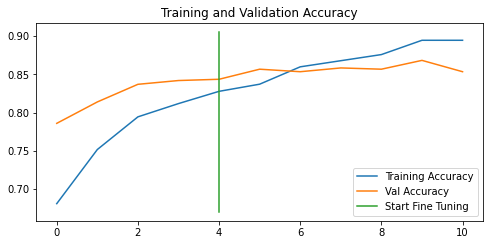

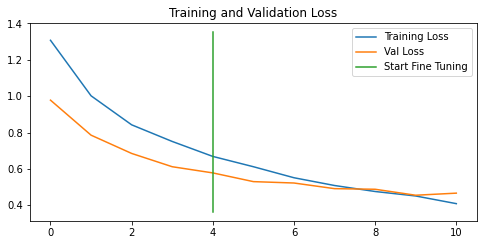

In [ ]:
compare_historys(history_2, model_3_history )

## Model 4

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

unzip_data("10_food_classes_all_data.zip")

In [ ]:
train_dir_all = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

In [ ]:
# creating dataloaders
IMG_SIZE = (224,224)
train_data_all = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all,
                                                                      label_mode="categorical",
                                                                      image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                  label_mode="categorical",
                                                                  image_size=IMG_SIZE)

To train a fine-tuning model (model_4), we need to revert model_2 back to its feature extraction weights


In [ ]:
model_2.load_weights(checkpoint_path)

In [ ]:
model_2.evaluate(test_data)

In [ ]:
for layer in model_2.layers[2].layers:
  print(layer.name, layer.trainable)

In [ ]:
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(lr=1e-4),
                metrics=["accuracy"])

history_fine_10_full = model_2.fit(train_data_all,
                                  epochs=10,
                                   validation_data=test_data,
                                   validation_steps=int(.25*len(test_data)),
                                   initial_epoch=history_2.epoch[-1])

In [ ]:
results_fine_tune_full_data = model_2.evaluate(test_data)

In [ ]:
compare_historys(history_2,history_fine_10_full)

# Scaling Up

In [1]:
!wget https://raw.githubusercontent.com/MateusFauri/TensorFlow-/main/helper_functions.py

--2023-04-05 17:55:50--  https://raw.githubusercontent.com/MateusFauri/TensorFlow-/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3984 (3.9K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   3.89K  --.-KB/s    in 0s      

2023-04-05 17:55:51 (61.7 MB/s) - ‘helper_functions.py’ saved [3984/3984]



In [2]:
import helper_functions as hf

In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
hf.unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2023-04-05 17:55:54--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 108.177.127.128, 172.217.218.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  39.6MB/s    in 40s     

2023-04-05 17:56:34 (38.3 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [4]:
import tensorflow as tf

IMG_SIZE = (224,224)

train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)
test_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                               label_mode="categorical",
                                                                               image_size=IMG_SIZE,
                                                                               shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [5]:
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only = True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

In [8]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(.2),
    preprocessing.RandomHeight(.2),
    preprocessing.RandomWidth(.2),
    preprocessing.RandomZoom(.2)
], name = "data_augmentation")

In [9]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

inputs = layers.Input(shape=(224,224,3), name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 1s 0us/step


In [11]:
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                    epochs=5,
                    validation_data=test_data_all_10_percent,
                    validation_steps=int(.15 * len(test_data_all_10_percent)),
                    callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 126s 423ms/step - loss: 3.3824 - accuracy: 0.2705 - val_loss: 2.4669 - val_accuracy: 0.4645
Epoch 2/5
237/237 [==============================] - 74s 309ms/step - loss: 2.2022 - accuracy: 0.4953 - val_loss: 2.0008 - val_accuracy: 0.5215
Epoch 3/5
237/237 [==============================] - 67s 279ms/step - loss: 1.8253 - accuracy: 0.5728 - val_loss: 1.8766 - val_accuracy: 0.5222
Epoch 4/5
237/237 [==============================] - 61s 256ms/step - loss: 1.6027 - accuracy: 0.6156 - val_loss: 1.7899 - val_accuracy: 0.5416
Epoch 5/5
237/237 [==============================] - 56s 235ms/step - loss: 1.4594 - accuracy: 0.6389 - val_loss: 1.7280 - val_accuracy: 0.5493


In [12]:
results_feature_extraction_model = model.evaluate(test_data_all_10_percent)

790/790 [==============================] - 62s 78ms/step - loss: 1.5839 - accuracy: 0.5827


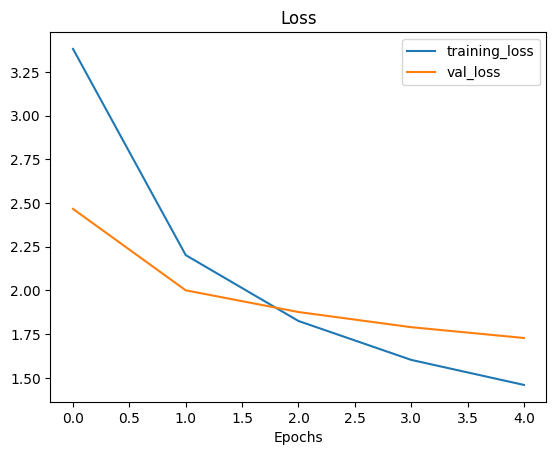

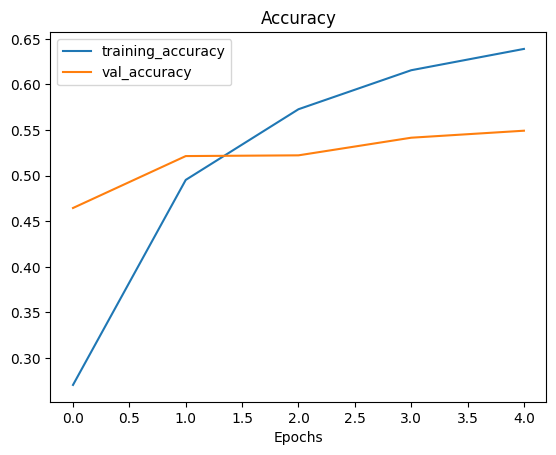

In [15]:
hf.plot_loss_curves(history_all_classes_10_percent)

In [18]:
base_model.trainable = True

for layer in base_model.layers[:-5]:
  layer.trainable = False

model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=["accuracy"])

fine_tune_epochs = 10

fine_tune_history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                            epochs=fine_tune_epochs,
                                            validation_data=test_data_all_10_percent,
                                            validation_steps=int(.15 * len(test_data_all_10_percent)),
                                            initial_epoch=history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 66s 230ms/step - loss: 1.2192 - accuracy: 0.6858 - val_loss: 1.7016 - val_accuracy: 0.5432
Epoch 6/10
237/237 [==============================] - 57s 240ms/step - loss: 1.0992 - accuracy: 0.7093 - val_loss: 1.6781 - val_accuracy: 0.5548
Epoch 7/10
237/237 [==============================] - 50s 208ms/step - loss: 0.9545 - accuracy: 0.7469 - val_loss: 1.6761 - val_accuracy: 0.5546
Epoch 9/10
237/237 [==============================] - 47s 195ms/step - loss: 0.8643 - accuracy: 0.7698 - val_loss: 1.6675 - val_accuracy: 0.5606
Epoch 10/10
237/237 [==============================] - 46s 191ms/step - loss: 0.8382 - accuracy: 0.7710 - val_loss: 1.6802 - val_accuracy: 0.5532


In [19]:
results_all_classes_10_percent_fine_tune = model.evaluate(test_data_all_10_percent)
results_all_classes_10_percent_fine_tune

790/790 [==============================] - 62s 79ms/step - loss: 1.4951 - accuracy: 0.6038


[1.4951106309890747, 0.6037623882293701]

In [21]:
hf.compare_historys(original_history=history_all_classes_10_percent,
                new_history=fine_tune_history_all_classes_10_percent,
                initial_epochs=5)

## Making Predictions

In [22]:
pred_probs = model.predict(test_data_all_10_percent, verbose=1)
pred_classes = pred_probs.argmax(axis=1)

pred_probs.shape

790/790 [==============================] - 68s 83ms/step


(25250, 101)

In [23]:
print(f"Number of prediction probabilities for sample 0: {len(pred_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {pred_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {pred_probs[0].argmax()}")
    

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like:
 [2.30674565e-01 2.97811872e-04 1.77471563e-01 3.68250369e-07
 1.22483225e-05 1.31556453e-06 4.15399118e-05 1.56480655e-06
 3.63546535e-02 4.46938531e-04 1.84033206e-06 1.78441178e-06
 1.86297490e-04 1.02458625e-06 4.97631822e-03 3.50750377e-03
 1.45502099e-05 2.89743138e-03 4.40202653e-03 6.25975827e-06
 1.14776904e-03 1.09668517e-05 2.47769785e-04 1.02984552e-04
 1.86052208e-03 2.21724482e-03 6.40343584e-04 5.85135531e-05
 1.84570625e-01 1.86632411e-03 1.42175668e-06 1.15240307e-03
 1.76996939e-04 5.91531204e-07 3.61101818e-03 3.20529216e-06
 5.95136189e-05 2.04627938e-03 4.33630161e-02 6.20703213e-05
 5.52294485e-04 9.56169982e-03 2.76594132e-04 4.81997131e-06
 6.94711925e-05 3.12675838e-05 3.59819946e-03 9.25128697e-05
 1.86939860e-06 8.55818093e-02 5.99365972e-04 8.99699444e-06
 2.73826104e-02 2.59035993e-02 2.10463058e-05 1.16564985e-02
 3.12526226e-02 1.51104934e-03 1.90123112e-

In [27]:
y_labels = []
for images, labels in test_data_all_10_percent.unbatch():
  y_labels.append(labels.numpy().argmax()) 
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [28]:
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.6037623762376237

In [29]:
class_names = test_data_all_10_percent.class_names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [30]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

              precision    recall  f1-score   support

           0       0.34      0.20      0.25       250
           1       0.49      0.72      0.58       250
           2       0.67      0.58      0.62       250
           3       0.75      0.61      0.67       250
           4       0.50      0.46      0.48       250
           5       0.50      0.41      0.45       250
           6       0.78      0.76      0.77       250
           7       0.85      0.75      0.80       250
           8       0.23      0.59      0.33       250
           9       0.45      0.62      0.52       250
          10       0.46      0.47      0.46       250
          11       0.85      0.53      0.65       250
          12       0.73      0.57      0.64       250
          13       0.53      0.56      0.55       250
          14       0.57      0.48      0.52       250
          15       0.39      0.42      0.41       250
          16       0.72      0.53      0.61       250
          17       0.36    

{'0': {'precision': 0.33774834437086093,
  'recall': 0.204,
  'f1-score': 0.2543640897755611,
  'support': 250},
 '1': {'precision': 0.4905149051490515,
  'recall': 0.724,
  'f1-score': 0.5848142164781905,
  'support': 250},
 '2': {'precision': 0.6666666666666666,
  'recall': 0.584,
  'f1-score': 0.6226012793176973,
  'support': 250},
 '3': {'precision': 0.7487684729064039,
  'recall': 0.608,
  'f1-score': 0.6710816777041941,
  'support': 250},
 '4': {'precision': 0.49783549783549785,
  'recall': 0.46,
  'f1-score': 0.47817047817047814,
  'support': 250},
 '5': {'precision': 0.5024390243902439,
  'recall': 0.412,
  'f1-score': 0.45274725274725275,
  'support': 250},
 '6': {'precision': 0.7842323651452282,
  'recall': 0.756,
  'f1-score': 0.7698574338085539,
  'support': 250},
 '7': {'precision': 0.8545454545454545,
  'recall': 0.752,
  'f1-score': 0.7999999999999999,
  'support': 250},
 '8': {'precision': 0.2301710730948678,
  'recall': 0.592,
  'f1-score': 0.33146696528555425,
  'supp

In [31]:
class_f1_scores = {}
for key, value in classification_report_dict.items():
  if key == "accuracy": 
    break
  else:
    class_f1_scores[class_names[int(key)]] = value["f1-score"]
class_f1_scores

{'apple_pie': 0.2543640897755611,
 'baby_back_ribs': 0.5848142164781905,
 'baklava': 0.6226012793176973,
 'beef_carpaccio': 0.6710816777041941,
 'beef_tartare': 0.47817047817047814,
 'beet_salad': 0.45274725274725275,
 'beignets': 0.7698574338085539,
 'bibimbap': 0.7999999999999999,
 'bread_pudding': 0.33146696528555425,
 'breakfast_burrito': 0.5183946488294314,
 'bruschetta': 0.4633663366336634,
 'caesar_salad': 0.6518518518518519,
 'cannoli': 0.6426966292134831,
 'caprese_salad': 0.5450980392156863,
 'carrot_cake': 0.5249457700650759,
 'ceviche': 0.40535372848948376,
 'cheese_plate': 0.608294930875576,
 'cheesecake': 0.41806020066889626,
 'chicken_curry': 0.477751756440281,
 'chicken_quesadilla': 0.6524271844660194,
 'chicken_wings': 0.7243460764587525,
 'chocolate_cake': 0.5593561368209256,
 'chocolate_mousse': 0.3625498007968128,
 'churros': 0.7300380228136881,
 'clam_chowder': 0.7045951859956237,
 'club_sandwich': 0.6830357142857143,
 'crab_cakes': 0.3765182186234817,
 'creme_brul

## Visualizing predictions

In [32]:
import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores

,class_name,f1-score
33,edamame,0.962525
63,macarons,0.901879
75,pho,0.860465
69,oysters,0.850895
32,dumplings,0.850806
...,...,...
8,bread_pudding,0.331467
77,pork_chop,0.331407
93,steak,0.314894
39,foie_gras,0.289086


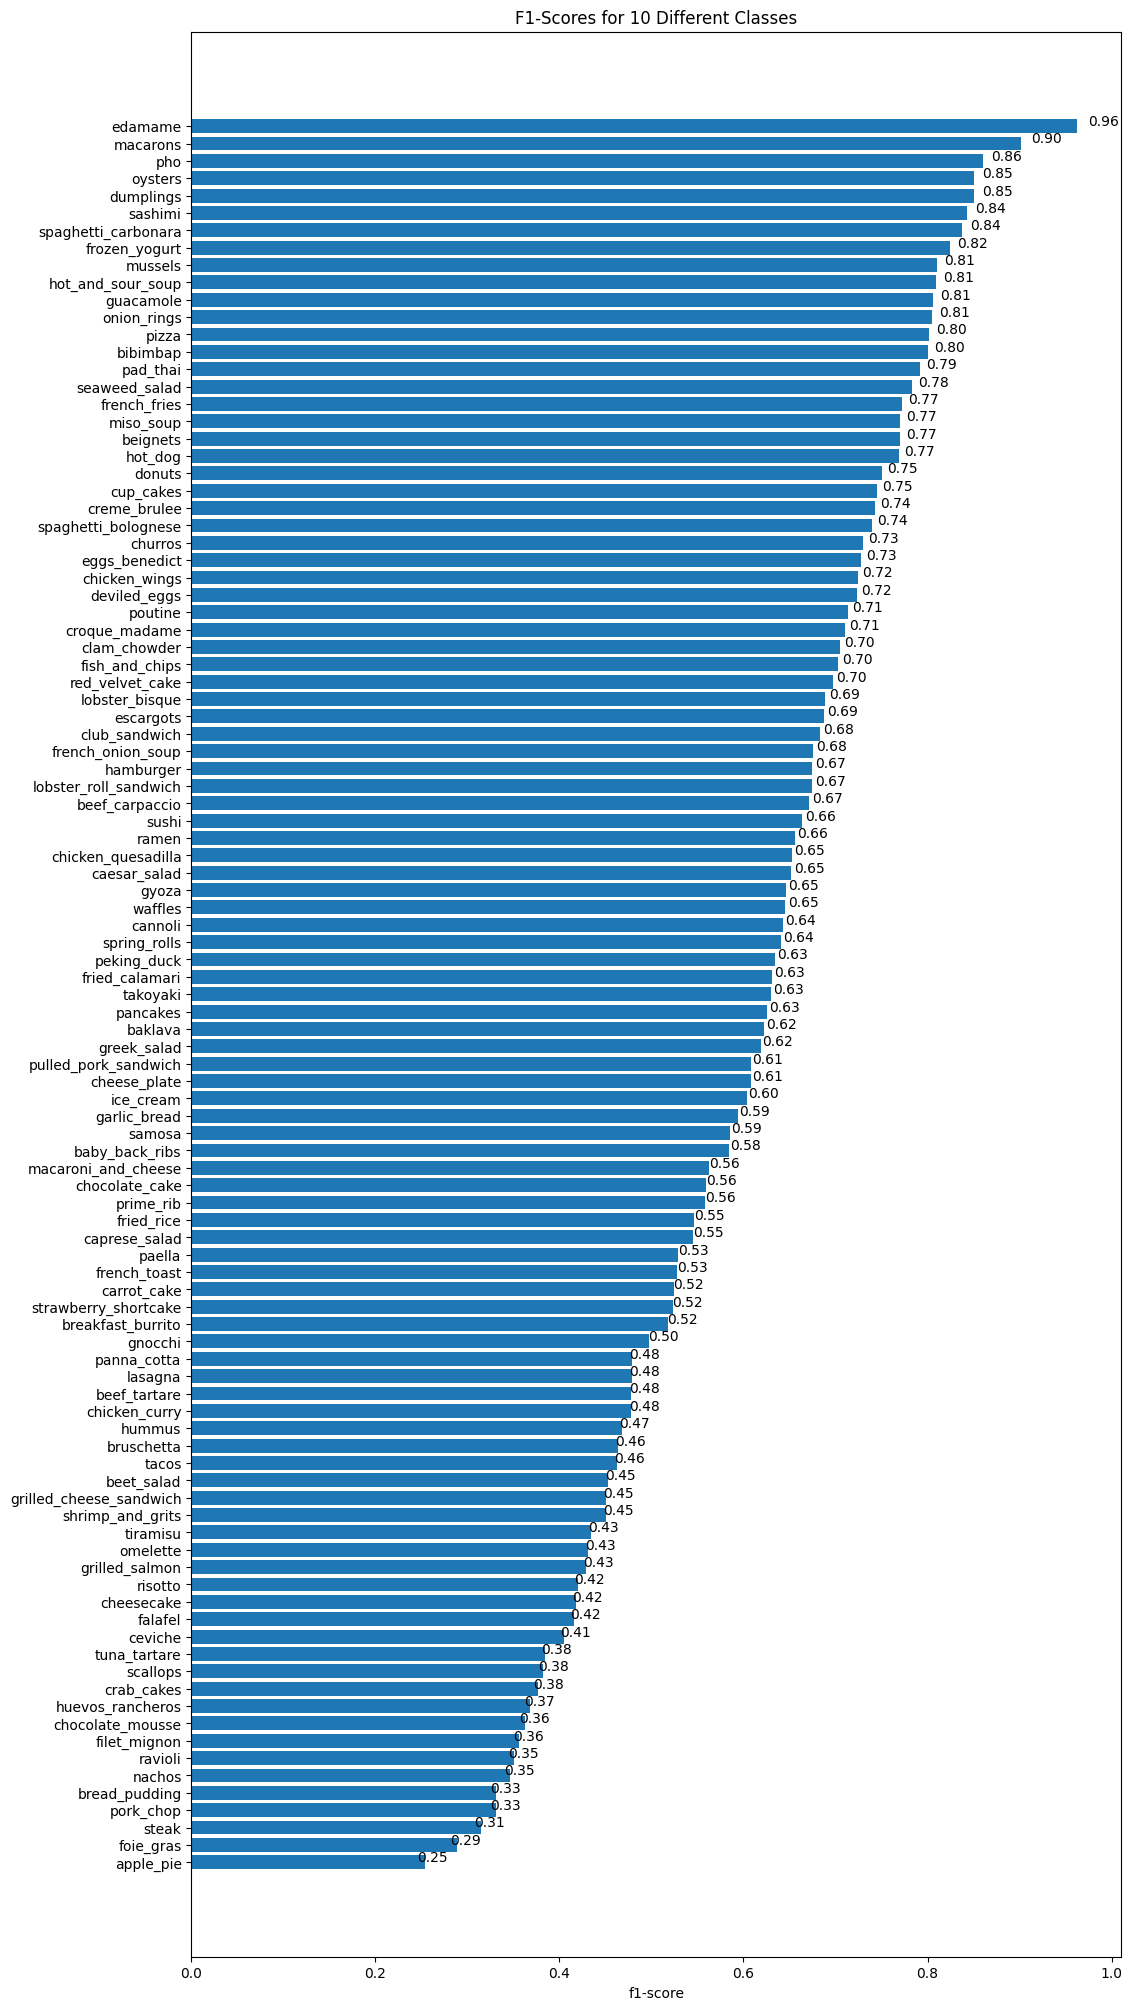

In [33]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); 

def autolabel(rects): 
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

## Visualizing prediction on test images

To visualize our model's predictions on our own images, we'll need a function to load and preprocess images, specifically it will need to:
* Read in a target image filepath using tf.io.read_file()
* Turn the image into a Tensor using tf.io.decode_image()
* Resize the image tensor to be the same size as the images our model has trained on using tf.image.resize()
* Scale the image to get all of the pixel values betwenn 0 & 1 (if necessary)


In [34]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
    Reads in an image from filename, turns it into a tensor and reshapes into 
    specified shape (img_shape, img_shape, color_channels=3)

    Args:
      Filename (str): path to target image
      image_shape (int): height/width dimension of target image size
      scale (bool): scale pixel values from 0-255 to 0-1 or not

    Return:
      Image tensor of shape (img_shape, img_shape, 3)
  """
  img = tf.io.read_file(filename)

  img = tf.io.decode_image(img, channels=3)

  img = tf.image.resize(img, [img_shape, img_shape])

  if scale:
    return img/255.
  else:
    return img

1/1 [==============================] - 0s 25ms/step


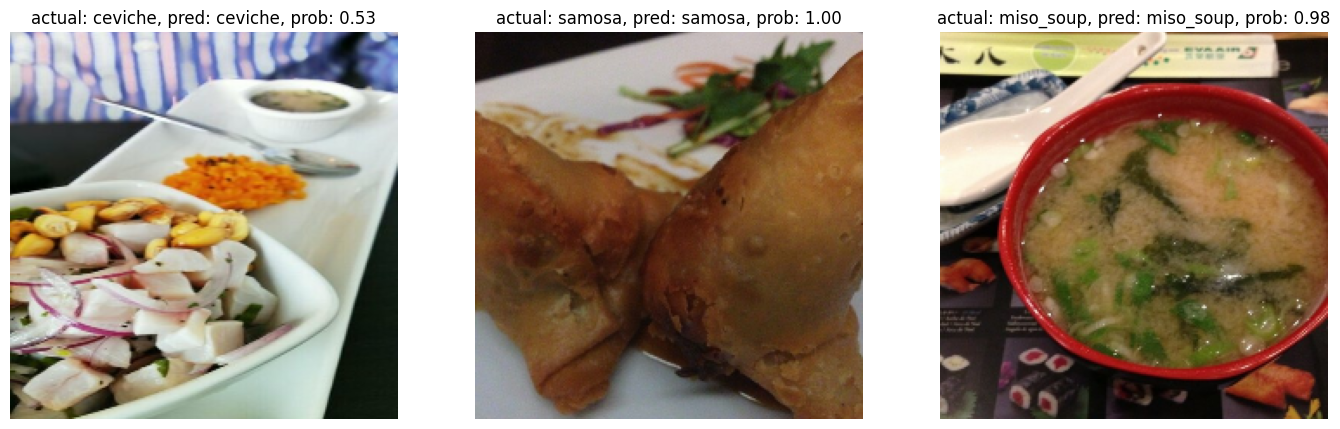

In [39]:
import os
import random

plt.figure(figsize=(17,10))
for i in range(3):
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + "/" + class_name + "/" + filename
  
  img = load_and_prep_image(filepath, scale=False)
  pred_prob = model.predict(tf.expand_dims(img, axis=0))
  pred_class = class_names[pred_prob.argmax()]
  # print(pred_prob, pred_class)

  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_names == pred_class:
    title_color = 'g'
  else:
    title_color = 'r'
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)

## Finding the most wrong predictions

In [40]:
filepaths = []
for filepath in test_data_all_10_percent.list_files("/content/101_food_classes_10_percent/test/*/*.jpg",
                                     shuffle=False):
  filepaths.append(filepath.numpy())

pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": pred_probs.max(axis=1), 
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]}) 
pred_df.head()

pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]


In [41]:
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]


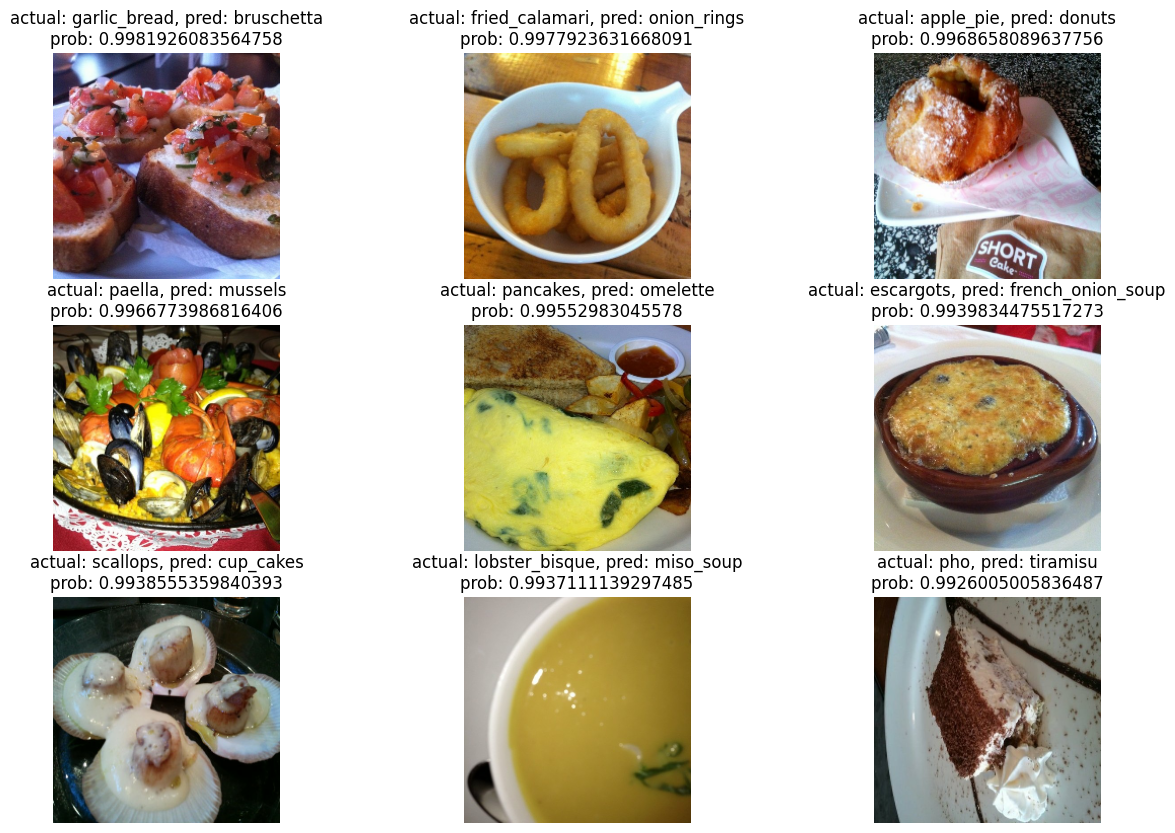

In [43]:
images_to_view = 9
start_index = 0
plt.figure(figsize=(15,10))

for i, row in enumerate(top_100_wrong[start_index : start_index+images_to_view].itertuples()):
  plt.subplot(3,3, i+1)
  img = load_and_prep_image(row[1], scale=False)
  _,_,_,_, pred_prob, y_true_classname, y_pred_classname, _ = row
  plt.imshow(img/255.)
  plt.title(f"actual: {y_true_classname}, pred: {y_pred_classname}\nprob: {pred_prob}")
  plt.axis(False)